# Gaussian Mixture Models (GMMs)

Gaussian Mixture Models (GMMs) are a type of probabilistic model that assumes data points are generated from a mixture of several Gaussian distributions. Unlike KMeans, which assigns each point to a single cluster, GMMs calculate the probability that each point belongs to each Gaussian distribution, allowing for **soft clustering**.

This flexibility helps GMMs better fit clusters that are not perfectly circular or spherical, as they can account for **different shapes, sizes, and orientations**.

### Key Concepts

- **Gaussian Distribution**: Each cluster in GMM is modeled by a Gaussian distribution, which has parameters like mean, variance, and potentially covariance.
- **Soft Clustering**: Instead of hard assignments, GMMs assign probabilities to each point indicating its likelihood of belonging to each cluster.
- **Expectation-Maximization (EM)**: The EM algorithm is used to fit GMM parameters, iteratively adjusting the model to maximize the likelihood of the data.

In this notebook, we'll explore how GMMs work, implement them using `sklearn`, and apply them to real-world data for clustering tasks.


## Expectation-Maximization (EM) Algorithm

To understand Gaussian Mixture Models, it’s important to first understand the **Expectation-Maximization (EM)** algorithm, which is central to the GMM approach.

### The EM Algorithm Overview

The EM algorithm is an iterative process to optimize model parameters, especially in situations where we have **latent variables** (hidden information about which cluster each data point belongs to). EM consists of two main steps:

1. **Expectation (E-Step)**: Calculate the probability that each data point belongs to each cluster based on the current parameter estimates.
2. **Maximization (M-Step)**: Update the parameters (mean, covariance, and weight of each Gaussian) to maximize the likelihood of data given the current cluster assignments.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.patches as patches

A **Gaussian Mixture Model** assumes that the data is generated from a mixture of several Gaussian distributions. Each Gaussian represents a cluster, and each data point has a certain probability of belonging to each cluster.

For a dataset $ X = \{ x_1, x_2, ..., x_n \} $, GMM aims to find:

- **Means** $ \mu_k $ of each Gaussian
- **Covariances** $ \Sigma_k $ of each Gaussian
- **Weights** $ \pi_k $ representing the probability of each cluster

For each cluster $ k $:

- **Mean** $ \mu_k $: Center of the Gaussian cluster
- **Covariance** $ \Sigma_k $: Spread of the Gaussian around the mean
- **Weight** $ \pi_k $: Proportion of data points belonging to that cluster


In [21]:
np.random.seed(42)
mean1 = [0, 0]
cov1 = [[1, 0.5], [0.5, 1]]
data1 = np.random.multivariate_normal(mean1, cov1, 150)

mean2 = [3, 5]
cov2 = [[1, -0.3], [-0.3, 1]]
data2 = np.random.multivariate_normal(mean2, cov2, 150)

# Combine data into a single dataset
data = np.vstack((data1, data2))

Helper function for plotting


In [22]:
def plot_gmm(data, means, covariances, iteration):
    plt.figure(figsize=(8, 8))
    plt.scatter(data[:, 0], data[:, 1], s=20, color='gray', alpha=0.5, label='Data')

    for i, (mean, cov) in enumerate(zip(means, covariances)):
        plt.scatter(mean[0], mean[1], color='red', marker='x', s=100, label=f'Centroid {i+1}')
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = patches.Ellipse(mean, width, height, angle, edgecolor='blue', facecolor='none', linewidth=2)
        plt.gca().add_patch(ellipse)

    plt.title(f"GMM - Iteration {iteration}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

### Initialization

1. **Randomly initialize the means $ \mu_k $** for each cluster $ k $.
2. Set **initial covariances $ \Sigma_k $** as identity matrices (same variance in all directions).
3. Assign **equal weights $ \pi_k = \frac{1}{K} $**, assuming each cluster is equally likely at the start.


In [36]:
# np.random.seed(1)
k = 2  # Number of clusters
n, d = data.shape

# Random initialization for means, covariances, and responsibilities
means = np.random.rand(k, d) 
covariances = [np.eye(d) for _ in range(k)]
weights = np.ones(k) / k  # Equal initial weights

# Convergence parameters
tolerance = 1e-3
max_iterations = 100

In [37]:
means, covariances, weights

(array([[0.14675589, 0.09233859],
        [0.18626021, 0.34556073]]),
 [array([[1., 0.],
         [0., 1.]]),
  array([[1., 0.],
         [0., 1.]])],
 array([0.5, 0.5]))

The EM algorithm iterates between two main steps until convergence:

1. **Expectation (E-Step)**
2. **Maximization (M-Step)**

#### 1. E-Step: Compute Responsibilities

In the **E-Step**, we calculate the **responsibility** $ \gamma\_{ik} $ of each cluster $ k $ for each data point $ x_i $. This responsibility indicates the probability that $ x_i $ belongs to cluster $ k $.

For each point $ x_i $:

- Calculate the probability density of $ x_i $ under each Gaussian component $ k $ using the **multivariate normal distribution**:

  $$
  p(x_i | \mu_k, \Sigma_k) = \frac{1}{\sqrt{(2 \pi)^d |\Sigma_k|}} \exp\left( -\frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) \right)
  $$

- Compute the responsibility $ \gamma\_{ik} $:
  $$
  \gamma_{ik} = \frac{\pi_k \, p(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \, p(x_i | \mu_j, \Sigma_j)}
  $$
  where $ \pi_k $ is the weight for cluster $ k $.

The result of this step is a matrix of responsibilities, where each entry $ \gamma\_{ik} $ represents the responsibility of cluster $ k $ for data point $ x_i $.

#### 2. M-Step: Update Parameters

In the **M-Step**, we update the **means**, **covariances**, and **weights** of each cluster based on the responsibilities computed in the E-Step.

1. **Update Mean $ \mu_k $**:

   - Each mean $ \mu*k $ is updated as a weighted average of all points, where weights are the responsibilities $ \gamma*{ik} $:
     $$
     \mu_k = \frac{\sum_{i=1}^{n} \gamma_{ik} \, x_i}{\sum_{i=1}^{n} \gamma_{ik}}
     $$

2. **Update Covariance $ \Sigma_k $**:

   - The covariance for each cluster $ k $ is updated by calculating the weighted spread of the data points around the new mean:
     $$
     \Sigma_k = \frac{\sum_{i=1}^{n} \gamma_{ik} \, (x_i - \mu_k)(x_i - \mu_k)^T}{\sum_{i=1}^{n} \gamma_{ik}}
     $$

3. **Update Weight $ \pi_k $**:
   - The weight $ \pi_k $ (or prior probability of each cluster) is updated based on the proportion of data points assigned to each cluster:
     $$
     \pi_k = \frac{\sum_{i=1}^{n} \gamma_{ik}}{n}
     $$
     where $ n $ is the total number of data points.

---

### Convergence Check

To determine when to stop iterating, we check if the changes in **means** $ \mu_k $ and **covariances** $ \Sigma_k $ between iterations fall below a small threshold (tolerance). This indicates that the parameters have stabilized and further updates are minimal.

1. Calculate the difference between old and new values of $ \mu_k $ and $ \Sigma_k $.
2. If all differences are below a set tolerance (e.g., $ 1 \times 10^{-3} $), the algorithm has **converged**.


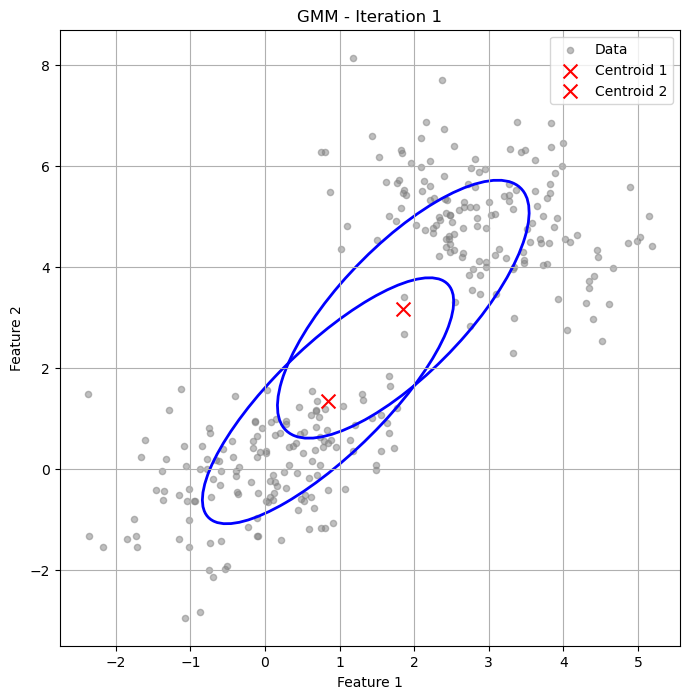

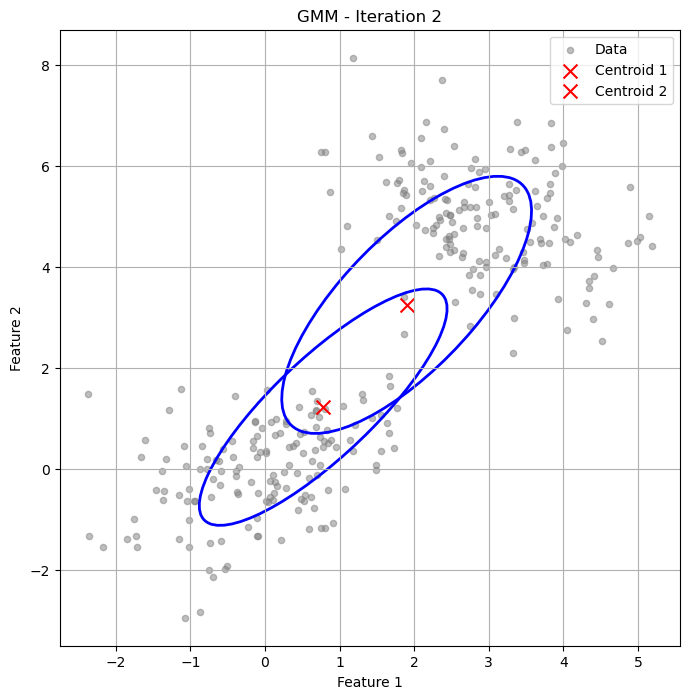

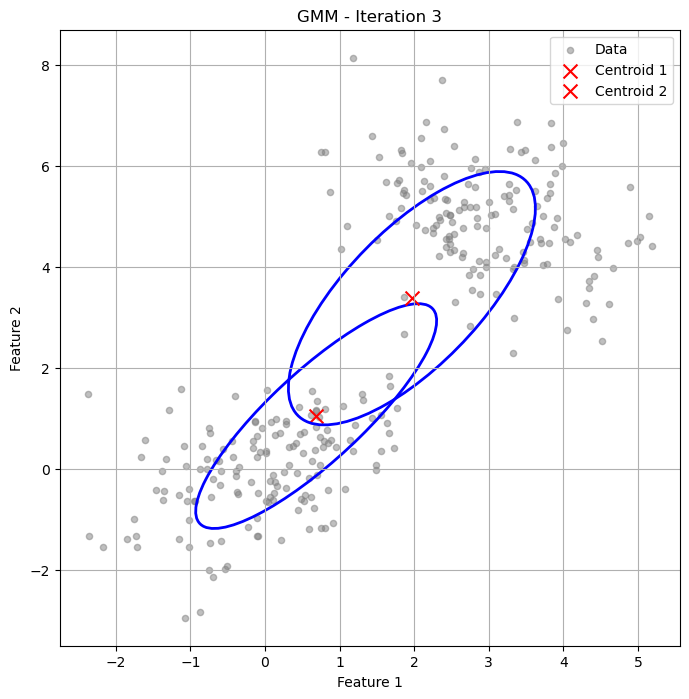

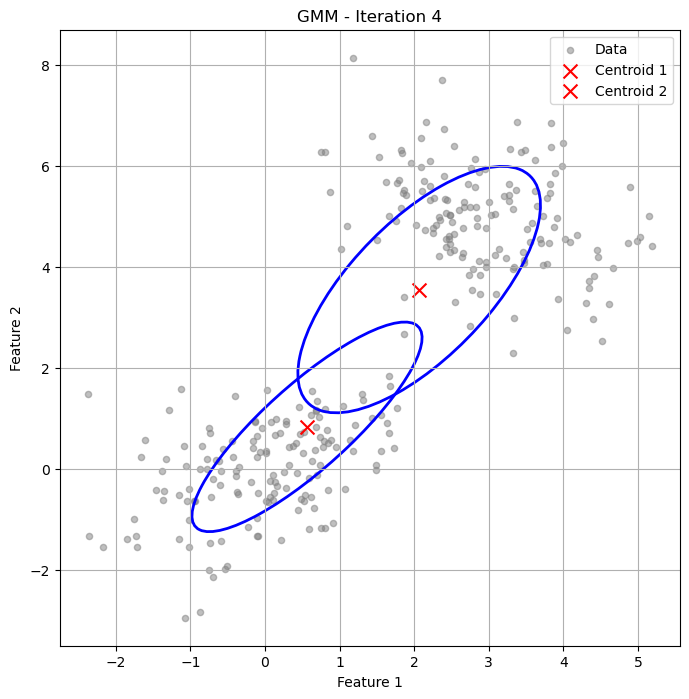

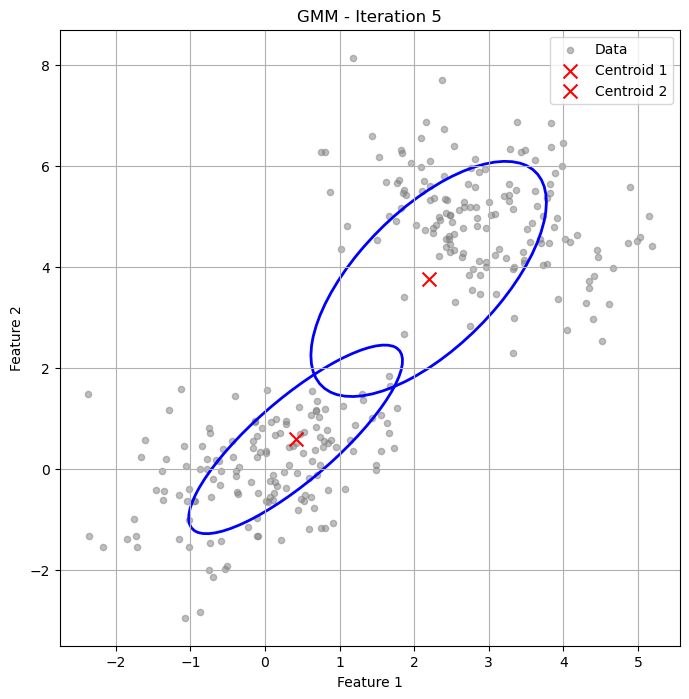

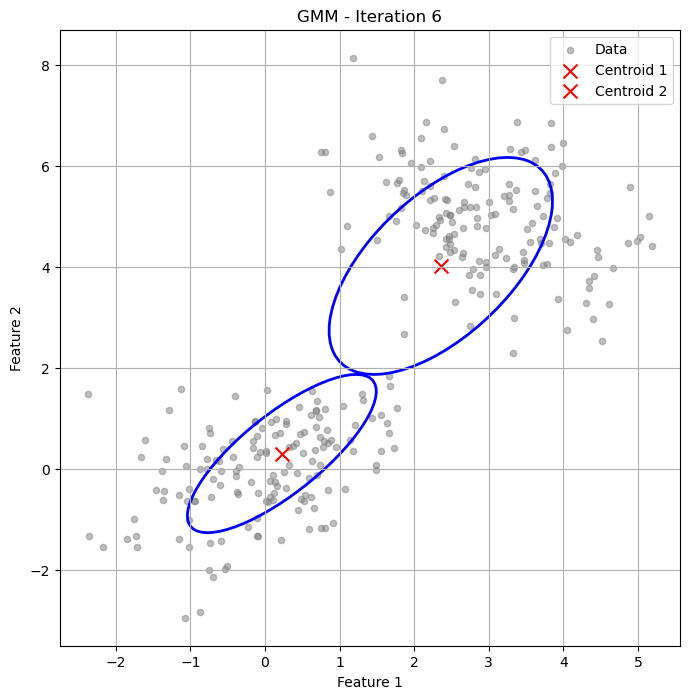

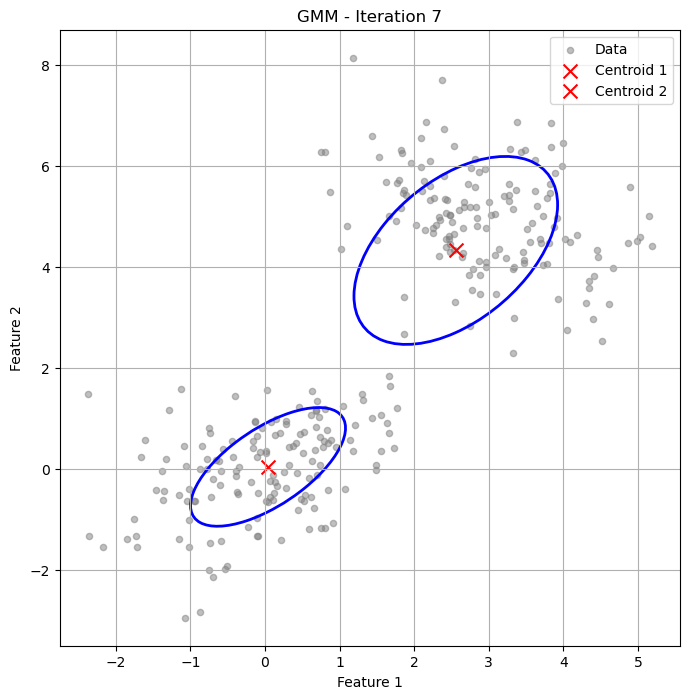

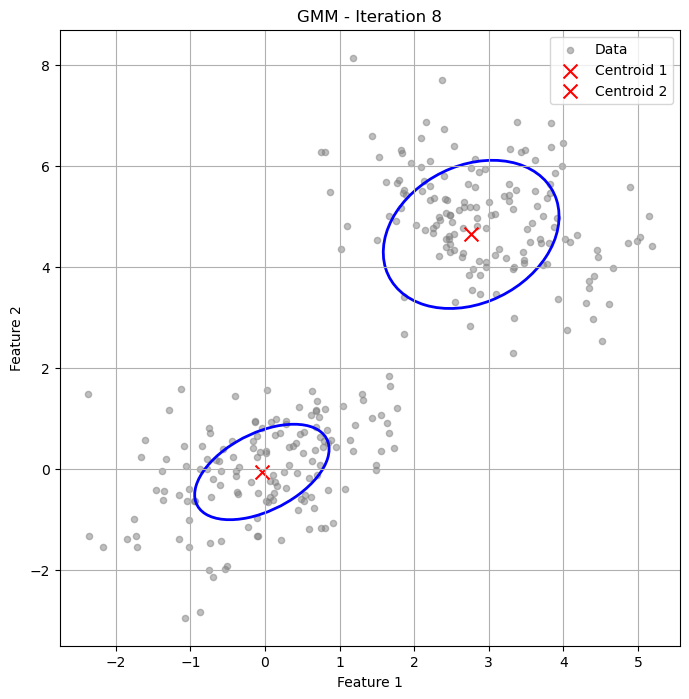

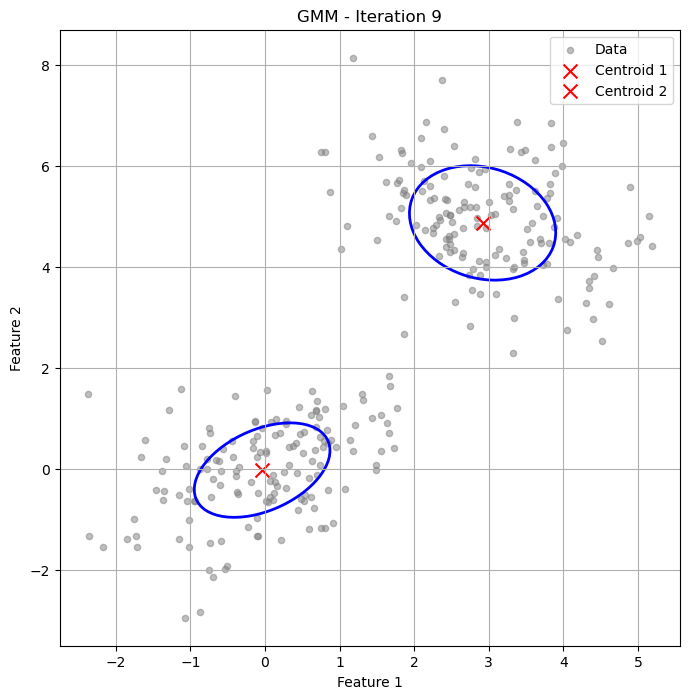

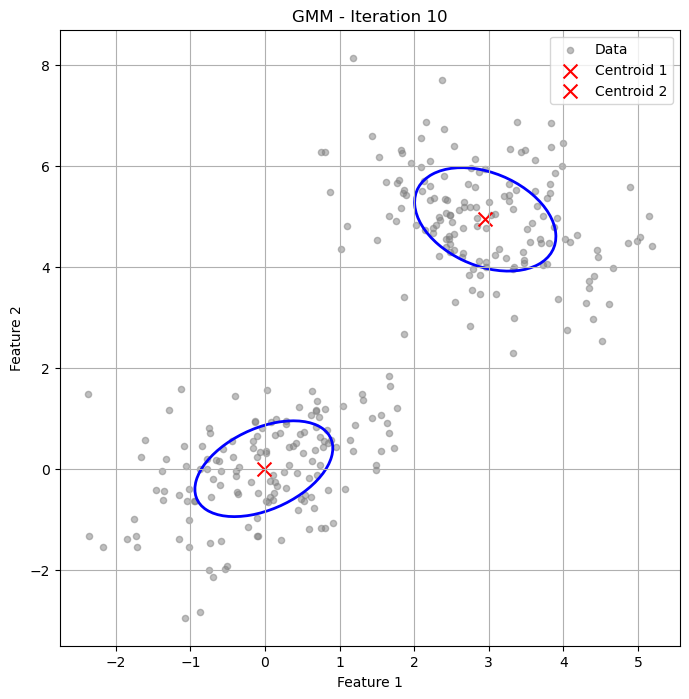

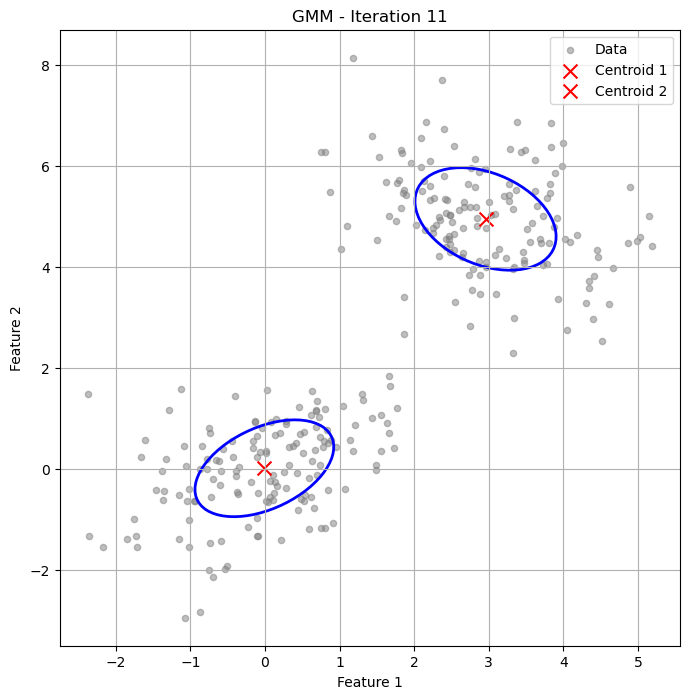

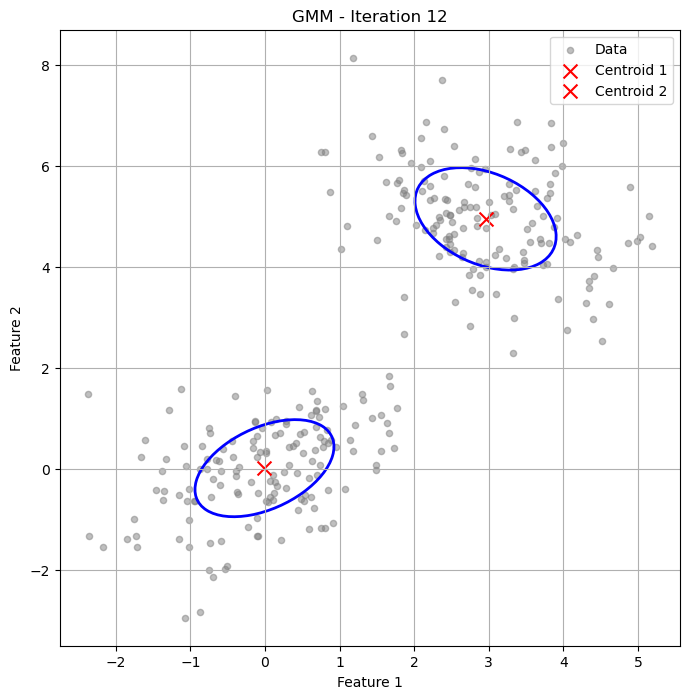

Convergence reached.
Final Means:
 [[-0.00661995  0.02142331]
 [ 2.95688787  4.9554218 ]]
Final Covariances:
 [array([[0.8675022 , 0.39584543],
       [0.39584543, 0.92264205]]), array([[ 0.89471502, -0.33251651],
       [-0.33251651,  1.02637257]])]
Final Weights:
 [0.49580587 0.50419413]


In [38]:
for iteration in range(max_iterations):
    # Step 1: E-Step - Compute responsibilities
    responsibilities = np.zeros((n, k))
    for i in range(k):
        responsibilities[:, i] = weights[i] * multivariate_normal.pdf(data, mean=means[i], cov=covariances[i])
    
    # Normalize responsibilities across clusters
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)

    # Step 2: M-Step - Update parameters based on responsibilities
    N_k = responsibilities.sum(axis=0)  # Effective number of points assigned to each cluster

    # Update means
    new_means = np.array([np.sum(responsibilities[:, i][:, np.newaxis] * data, axis=0) / N_k[i] for i in range(k)])
    
    # Update covariances
    new_covariances = []
    for i in range(k):
        diff = data - new_means[i]
        cov = (responsibilities[:, i][:, np.newaxis] * diff).T @ diff / N_k[i]
        new_covariances.append(cov)
    
    # Update weights
    new_weights = N_k / n

    # Convergence check
    if np.allclose(means, new_means, atol=tolerance) and \
       all(np.allclose(covariances[i], new_covariances[i], atol=tolerance) for i in range(k)):
        print("Convergence reached.")
        break
    
    # Update parameters
    means, covariances, weights = new_means, new_covariances, new_weights

    # Plot the current state of the GMM
    plot_gmm(data, means, covariances, iteration + 1)

# Final parameters
print("Final Means:\n", means)
print("Final Covariances:\n", covariances)
print("Final Weights:\n", weights)

## Sci-Kit Learn Implementation

In practice, we can use the `GaussianMixture` class from `sklearn.mixture` to fit a Gaussian Mixture Model to our data. This class provides a high-level interface to the EM algorithm for GMMs.


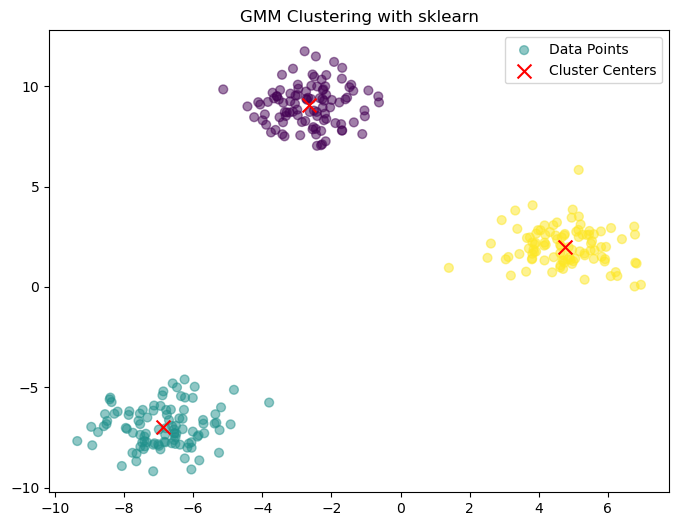

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

# Step 1: Generate synthetic data
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

# Step 2: Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X)

# Step 3: Predict cluster labels and get cluster centers
labels = gmm.predict(X)
probs = gmm.predict_proba(X)  # Probability of each point belonging to each cluster
centers = gmm.means_

# Step 4: Plot the data points with cluster centers
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=40, alpha=0.5, label="Data Points")
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100, label="Cluster Centers")
plt.title("GMM Clustering with sklearn")
plt.legend()
plt.show()


## Pros and Cons of Gaussian Mixture Models (GMM)

### Pros

1. **Soft Clustering**: Unlike k-means, GMMs assign probabilities to each data point for belonging to each cluster, allowing for "soft" cluster assignments. This flexibility is useful when data points may belong to multiple clusters.

2. **Clusters of Different Shapes and Sizes**: GMMs can capture clusters with varying shapes, orientations, and sizes, as each cluster is represented by a Gaussian distribution with its own covariance matrix.

3. **Versatile and Probabilistic Framework**: The probabilistic nature of GMMs provides more flexibility and interpretability, especially for applications like anomaly detection, where the probability of belonging to a cluster can indicate the "unusualness" of a point.

4. **Applicability to High-Dimensional Data**: GMMs work well in high-dimensional spaces, as the Gaussian components can model the data's variance in different dimensions.

5. **Expectation-Maximization (EM) Convergence**: The EM algorithm used for training GMMs typically converges quickly to a local optimum, making GMMs efficient for many clustering tasks.

### Cons

1. **Assumption of Gaussian Distributions**: GMMs assume that each cluster follows a Gaussian distribution. If this assumption doesn't hold, GMM may not perform well.

2. **Sensitivity to Initialization**: Similar to k-means, GMMs can be sensitive to the initialization of parameters (e.g., means, covariances, and weights), potentially leading to suboptimal solutions.

3. **Risk of Overfitting**: GMMs may overfit the data, especially with a high number of clusters or in cases where clusters overlap significantly. Selecting the correct number of clusters is crucial.

4. **Computational Complexity**: Fitting GMMs, especially in high-dimensional data, can be computationally expensive due to repeated EM steps and the calculation of covariance matrices.

5. **Local Optima**: The EM algorithm used in GMMs may converge to a local optimum rather than a global one, leading to inconsistent results on the same data with different initializations.

6. **Cluster Interpretation**: Unlike k-means, the clusters formed by GMMs can sometimes be challenging to interpret, as they don’t necessarily have the "hard" boundaries found in k-means clustering.
